In [1]:
%reload_ext autoreload
%autoreload 2

# Given EDA

In [ ]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import rasterio
from matplotlib import pyplot as plt
import os

In [4]:
def polygons_to_mask(image_size, polygons):
    """
    Draw each polygon with a unique ID (1..N) on the mask.
    """
    h, w = image_size
    mask = np.zeros((h, w), dtype=np.int32)

    for idx, poly in enumerate(polygons, start=1):
        pts = np.array(poly, dtype=np.int32)
        cv2.fillPoly(mask, [pts], idx)

    return mask

In [6]:
filename = "McCormick_25Apr01_0_2"
# annotation_file_path = f"./tree_data_for_instance_segmentation/{filename}.json"
# image_file_path = f"./tree_data_for_instance_segmentation/{filename}.tif"
annotation_file_path = os.path.join('tree_data_for_instance_segmentation', f'{filename}.json')
image_file_path = os.path.join('tree_data_for_instance_segmentation', f'{filename}.tif')

# Read RGB image
with rasterio.open(image_file_path) as src:
    image = np.moveaxis(src.read(), 0, -1)  # (H, W, C)

# Read annotation JSON
annotation_df = pd.read_json(annotation_file_path, orient='index').transpose()

# Collect all polygon coordinates
xy_coords = []
for shapes in annotation_df['shapes']:
    for shape in shapes:
        points = shape["points"]
        xy_coords.append([tuple(p) for p in points])

# --- Create instance mask ---
mask = polygons_to_mask(image.shape[:2], xy_coords)

# --- Assign random color to each instance ---
unique_ids = np.unique(mask)
unique_ids = unique_ids[unique_ids != 0]  # skip background

np.random.seed(42)
colors = {uid: np.random.randint(0, 255, size=3).tolist() for uid in unique_ids}

# --- Create RGB overlay ---
overlay = np.zeros_like(image, dtype=np.uint8)
for uid in unique_ids:
    overlay[mask == uid] = colors[uid]

# --- Blend overlay with image ---
blended = cv2.addWeighted(image, 0.85, overlay, 0.35, 0).astype('uint8')


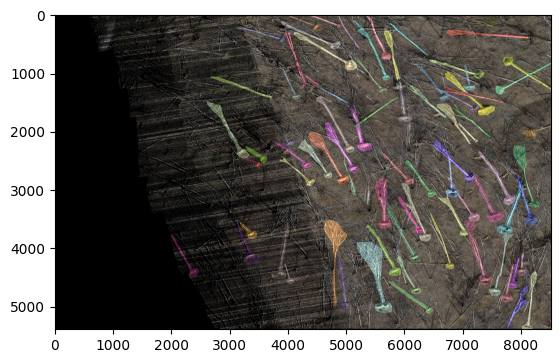

In [7]:
plt.imshow(blended)

# My Explore

In [8]:
import os
data_dir = "./tree_data_for_instance_segmentation"
files = os.listdir(data_dir)
print("Total files:", len(files))
print(files[:10])


Total files: 2
['McCormick_25Apr01_0_2.json', 'McCormick_25Apr01_0_2.tif']


In [9]:
import rasterio
img_path = os.path.join(data_dir, "McCormick_25Apr01_0_2.tif")
with rasterio.open(img_path) as src:
    print("Shape:", src.shape)
    print("Channels:", src.count)
    image = src.read().transpose(1,2,0)


Shape: (5390, 8517)
Channels: 3


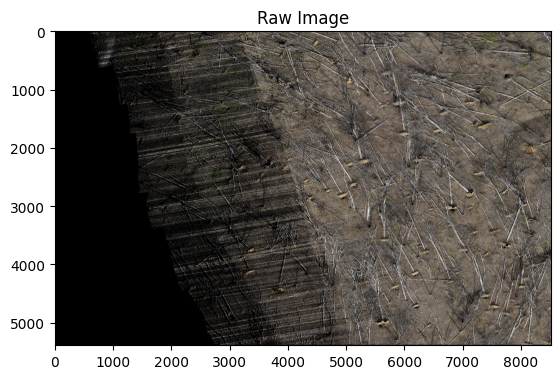

In [10]:
plt.imshow(image)
plt.title("Raw Image")
plt.show()


In [11]:
import pandas as pd
ann_path = os.path.join(data_dir, "McCormick_25Apr01_0_2.json")
annotation_df = pd.read_json(ann_path, orient='index').transpose()
annotation_df.keys()


Index(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight',
       'imageWidth'],
      dtype='object')

In [12]:
annotation_df["shapes"][0][0]

{'label': 'fallen_tree',
 'points': [[6143.2, 4687.0],
  [6096.378787878788, 4723.787878787879],
  [6102.439393939394, 4757.121212121212],
  [6147.893939393939, 4787.424242424243],
  [6223.651515151515, 4793.484848484849],
  [6263.045454545454, 4769.242424242424],
  [6278.196969696969, 4723.787878787879],
  [6226.681818181818, 4663.181818181818],
  [6177.6, 4673.400000000001],
  [6105.469696969697, 4560.151515151515],
  [6067.2, 4491.8],
  [6030.4, 4427.8],
  [5987.287878787879, 4320.757575757576],
  [5960.015151515151, 4232.878787878788],
  [5929.712121212121, 4145.0],
  [5884.257575757576, 4145.0],
  [5856.984848484848, 4163.181818181818],
  [5850.924242424242, 4220.757575757576],
  [5885.6, 4251.8],
  [5969.6, 4355.0],
  [5983.2, 4453.400000000001],
  [6035.2, 4515.8],
  [6083.2, 4586.2],
  [6104.8, 4623.8],
  [6123.2, 4656.6]],
 'group_id': None,
 'description': '',
 'shape_type': 'polygon',
 'flags': {},
 'mask': None}

In [13]:
polygons = []
for shape in annotation_df["shapes"][0]:
    polygons.append(shape["points"])
print(f"Total polygons: {len(polygons)}")


Total polygons: 78


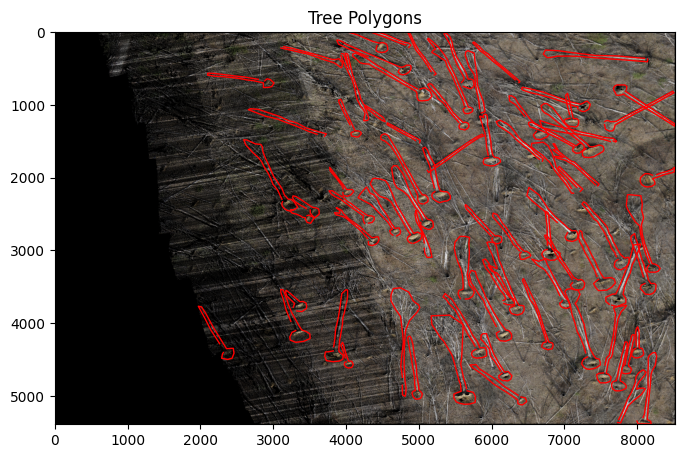

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(image)
for poly in polygons:
    poly = np.array(poly)
    plt.plot(poly[:,0], poly[:,1], color="red", linewidth=1)
plt.title("Tree Polygons")
plt.show()
